<a href="https://colab.research.google.com/github/vic1030/Data_Science_Learning/blob/main/Kmeans%2Bdbscan%2B%E5%8D%8A%E7%9B%91%E7%9D%A3%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 聚类算法实践
- Kmeans与Dbscan算法
- 半监督问题解决方案
- 聚类评估方法

![title](./img/1.png)

In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### Kmeans
***P78-2***

In [2]:
from sklearn.datasets import make_blobs
#构建五个中心点（也就是五个簇，一会围绕着发散）
blob_centers = np.array(
    [[0.2,2.3],
     [-1.5,2.3],
     [-2.8,1.8],
     [-2.8,2.8],
     [-2.8,1.3]])

blob_std =np.array([0.4,0.3,0.1,0.1,0.1])

In [3]:
X,y = make_blobs(n_samples=2000,centers=blob_centers,
                     cluster_std = blob_std,random_state=7) #发散程度有多大

#这里的X就是一些二维数据 x1 x2, y不需要参与因为是无监督任务

In [4]:
y

array([4, 2, 0, ..., 3, 0, 2])

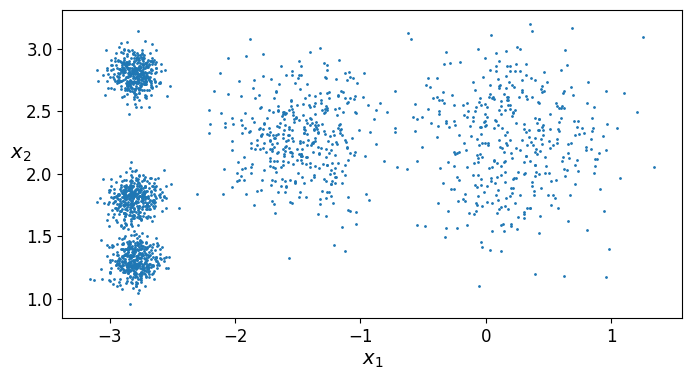

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### 决策边界

In [6]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters = k,random_state=42)
y_pred =  kmeans.fit_predict(X)

***fit_predict(X)与kmeans.labels_ 得到预测结果是一致的 ***

In [7]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [8]:
kmeans.labels_

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [9]:
kmeans.cluster_centers_ #看看能得到几个中心点，和k值一样，这里k是5

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

In [10]:
X_new = np.array([[0,2],[3,2],[-3,3],[-3,2.5]]) #构造一份测试数据
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

In [11]:
kmeans.transform(X_new) #transform会得到每个样本到中心点的距离，几个样本就会得到几个维度，此例是4个簇所以4行。
#2.8就表示第一个样本到第一个中心点的距离

array([[2.83778629, 0.59082671, 1.4955481 , 2.9042344 , 0.31493543],
       [5.81943941, 2.9710039 , 4.47759126, 5.84739223, 2.68685968],
       [1.4618254 , 3.11488787, 1.6912185 , 0.29040966, 3.47026031],
       [0.96879317, 3.08818836, 1.54672634, 0.36159148, 3.35573094]])

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2) #数据展示，此例是二维数据

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=120, linewidths=2,  # Adjust size and line width of circle
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=100, linewidths=2,  # Adjust size and line width of cross
                color=cross_color, zorder=11, alpha=1)

#绘制决策边界
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    #组合棋盘
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #绘制等高线
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids: #要不要展示中心点
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=7)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')

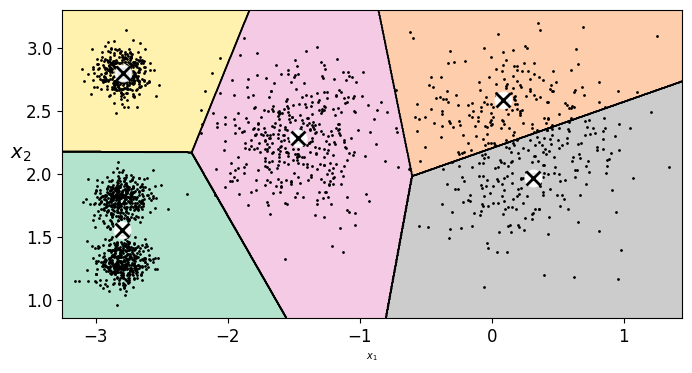

In [13]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### 算法流程

此处展示kmeans每走一步迭代的样子

In [14]:
kmeans_iter1 = KMeans(n_clusters = 5,
                      init = 'random',#随机初始位置选择
                      n_init = 1,#kmeans在不同簇心中测试，会选择inertia值效果最好的一次，默认10
                      max_iter=1,random_state=1)
kmeans_iter2 = KMeans(n_clusters = 5,init = 'random',n_init = 1,max_iter=2,random_state=1)
kmeans_iter3 = KMeans(n_clusters = 5,init = 'random',n_init = 1,max_iter=3,random_state=1)

kmeans_iter1.fit(X) #第一次迭代
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=1)

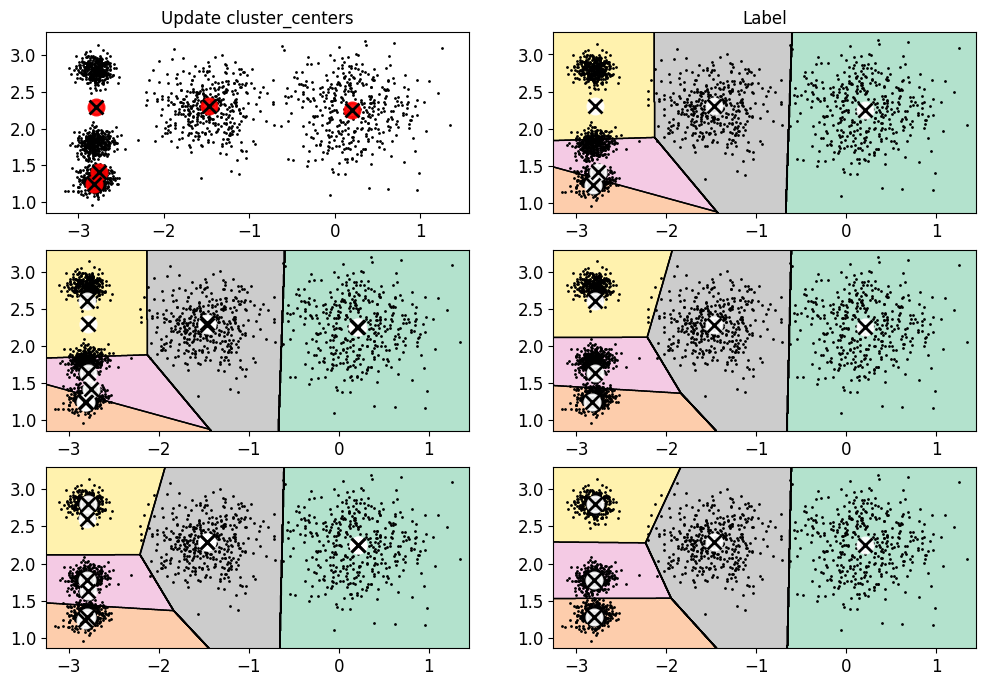

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='k')
plt.title('Update cluster_centers')

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X,show_xlabels=False, show_ylabels=False)
plt.title('Label')

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X,show_xlabels=False, show_ylabels=False)
plot_centroids(kmeans_iter2.cluster_centers_,)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X,show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X,show_xlabels=False, show_ylabels=False)
plot_centroids(kmeans_iter3.cluster_centers_,)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X,show_xlabels=False, show_ylabels=False)

plt.show()



### 不稳定的结果
随着随机种子的不同，初始位置也不同。

In [16]:
def plot_clusterer_comparison(c1,c2,X):
    c1.fit(X)
    c2.fit(X)

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_decision_boundaries(c1,X)
    plt.subplot(122)
    plot_decision_boundaries(c2,X)

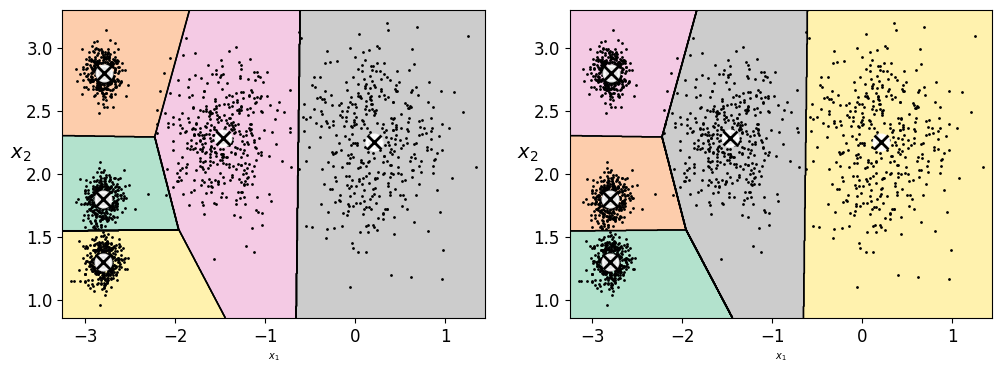

In [17]:
c1 = KMeans(n_clusters = 5,init='random',n_init = 1,random_state=11)
c2 = KMeans(n_clusters = 5,init='random',n_init = 1,random_state=19)
plot_clusterer_comparison(c1,c2,X)


### 评估方法
- Inertia指标：每个样本与其质心的距离

In [18]:
kmeans.inertia_

219.42800073647606

In [19]:
X_dist = kmeans.transform(X)

transform得到的是当前样本到每个簇中心距离

In [20]:
kmeans.transform(X)

array([[0.23085922, 3.04838567, 1.54568385, 1.45402521, 3.07528232],
       [0.26810747, 3.06126045, 1.48314418, 0.99002955, 3.19186267],
       [3.78216716, 1.66209651, 2.67172567, 4.09069201, 1.02742236],
       ...,
       [1.17785478, 2.89371096, 1.4073312 , 0.06769209, 3.20799557],
       [3.15905017, 0.23914671, 1.71339651, 3.05913478, 0.43887998],
       [0.43658314, 2.79657627, 1.21395695, 0.85434589, 2.95143035]])

In [21]:
kmeans.labels_

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [22]:
#手动找一下total inertia，其实就是每一个样本到它的最近处的一个距离的平方和加在一起,越小越好

In [23]:
X_dist[np.arange(len(X_dist)),kmeans.labels_]

array([0.23085922, 0.26810747, 1.02742236, ..., 0.06769209, 0.23914671,
       0.43658314])

In [24]:
np.sum(X_dist[np.arange(len(X_dist)),kmeans.labels_]**2)

219.42800073647567

In [25]:
#还有一个办法找到inertia，只是去掉负号

In [26]:
kmeans.score(X)

-219.4280007364761

In [27]:
c1.inertia_

211.59853725816828

In [28]:
c2.inertia_

211.59853725816828

### 找到最佳簇数

如果k值越大，得到的结果肯定会越来越小！！！

In [29]:
#寻找最合适的k的一个手段，未必完全遵守
kmeans_per_k = [KMeans(n_clusters = k).fit(X) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

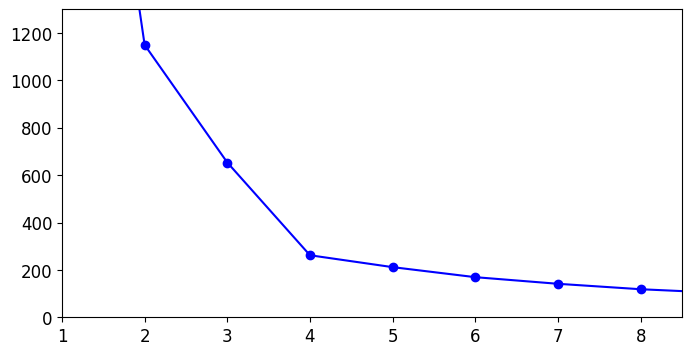

In [30]:
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.axis([1,8.5,0,1300])
plt.show()

### 轮廓系数 寻找合适k的另一手段

- $ai$: 计算样本i到同簇其他样本的平均距离ai。ai 越小，说明样本i越应该被聚类到该簇。将ai 称为样本i的簇内不相似度。
- $bi$: 计算样本i到其他某簇Cj 的所有样本的平均距离bij，称为样本i与簇Cj 的不相似度。定义为样本i的簇间不相似度：bi =min{bi1, bi2, ..., bik}

我们希望ai小，bi大，**轮廓系数越接近1越好**

![title](./img/3.png)

结论：
- si接近1，则说明样本i聚类合理；

- si接近-1，则说明样本i更应该分类到另外的簇；

- 若si 近似为0，则说明样本i在两个簇的边界上。

In [31]:
from sklearn.metrics import silhouette_score
silhouette_score(X,kmeans.labels_)

0.6353422668284152

In [32]:
kmeans_per_k

[KMeans(n_clusters=1),
 KMeans(n_clusters=2),
 KMeans(n_clusters=3),
 KMeans(n_clusters=4),
 KMeans(n_clusters=5),
 KMeans(n_clusters=6),
 KMeans(n_clusters=7),
 KMeans(),
 KMeans(n_clusters=9)]

In [33]:
silhouette_scores = [silhouette_score(X,model.labels_) for model in kmeans_per_k[1:]]

In [34]:
silhouette_scores

[0.5966442557582528,
 0.5723900247411775,
 0.688531617595759,
 0.655517642572828,
 0.6020248775444942,
 0.6070979466596362,
 0.5614686225605264,
 0.567647042788722]

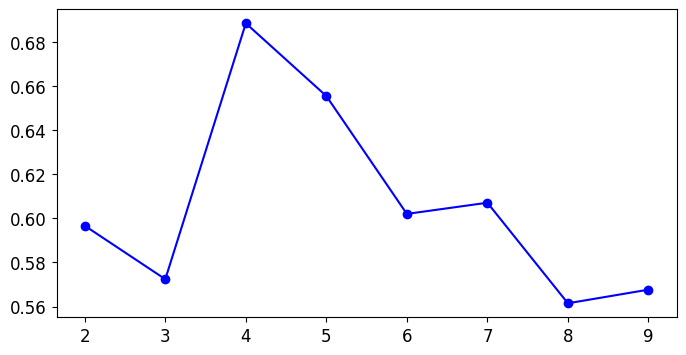

In [35]:
plt.figure(figsize=(8,4))
plt.plot(range(2,10),silhouette_scores,'bo-')
plt.show()

### Kmeans存在的问题

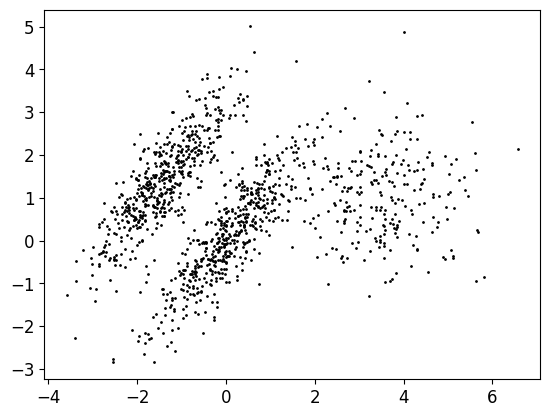

In [36]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_data(X)

In [37]:
kmeans_good = KMeans(n_clusters=3,init=np.array([[-1.5,2.5],[0.5,0],[4,0]]),n_init=1,random_state=42)
kmeans_bad = KMeans(n_clusters=3,random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Text(0.5, 1.0, 'Bad - inertia = 2179.6411978716374')

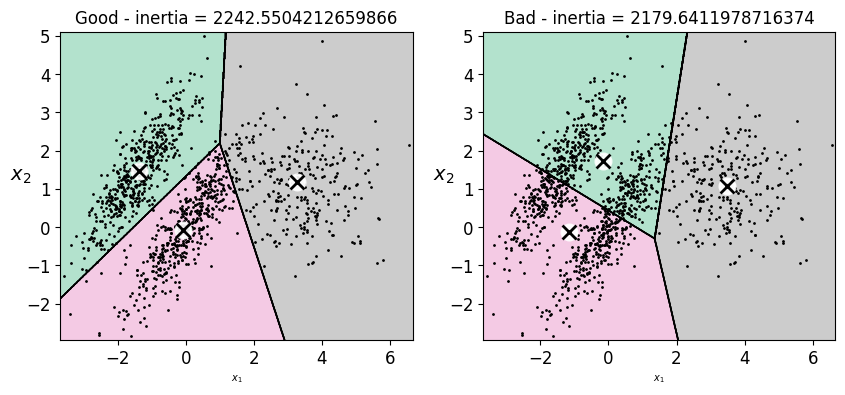

In [38]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plot_decision_boundaries(kmeans_good,X)
plt.title('Good - inertia = {}'.format(kmeans_good.inertia_))

plt.subplot(122)
plot_decision_boundaries(kmeans_bad,X)
plt.title('Bad - inertia = {}'.format(kmeans_bad.inertia_))
#评估标准只能到当作一个参考

### 图像分割小例子

In [39]:
#ladybug.png
from matplotlib.image import imread

image = imread('/ladybug.png')
image.shape #kmeans得用二维，但是这里显示三维

(533, 800, 3)

In [40]:
X = image.reshape(-1,3) #3个颜色，保留三个像素点。这里的-1表示上方三个数组相乘并/3
X.shape

(426400, 3)

In [41]:
kmeans = KMeans(n_clusters = 8,random_state=42).fit(X)

In [42]:
kmeans.cluster_centers_

array([[0.02180016, 0.10846606, 0.00570325],
       [0.9828916 , 0.9326364 , 0.02553773],
       [0.21327895, 0.3807754 , 0.05518298],
       [0.60839957, 0.6286125 , 0.3857063 ],
       [0.3668336 , 0.5195868 , 0.15321186],
       [0.09569374, 0.24873641, 0.01605126],
       [0.76465136, 0.20012419, 0.04390512],
       [0.8766142 , 0.7178749 , 0.03667176]], dtype=float32)

In [43]:
segmented_img = kmeans.cluster_centers_[kmeans.labels_].reshape(533, 800, 3)

In [44]:
segmented_imgs = []
n_colors = (10,8,6,4,2)
for n_cluster in n_colors:
    kmeans = KMeans(n_clusters = n_cluster,random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

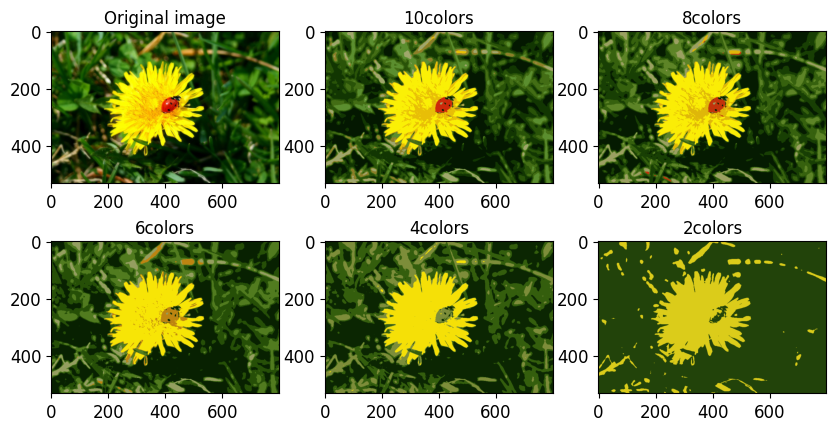

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(231)
plt.imshow(image)
plt.title('Original image')

for idx,n_clusters in enumerate(n_colors):
    plt.subplot(232+idx)
    plt.imshow(segmented_imgs[idx])
    plt.title('{}colors'.format(n_clusters))

### 半监督学习

P83-40

首先，让我们将训练集聚类为50个集群，
然后对于每个聚类，让我们找到最靠近质心的图像。 我们将这些图像称为代表性图像：

In [72]:
from sklearn.datasets import load_digits

X_digits,y_digits = load_digits(return_X_y = True)

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_digits,y_digits,random_state=42)

In [73]:
y_train.shape

(1347,)

In [74]:
from sklearn.linear_model import LogisticRegression
n_labeled = 50

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8266666666666667

In [75]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

In [76]:
X_digits_dist.shape #当前有1347个样本，但是有50个簇

(1347, 50)

In [77]:
representative_digits_idx = np.argmin(X_digits_dist,axis=0) #每个数去找离当前50个簇中心最近的点
representative_digits_idx.shape

(50,)

In [78]:
X_representative_digits = X_train[representative_digits_idx]

现在让我们绘制这些代表性图像并手动标记它们：

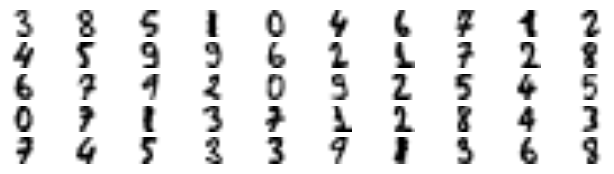

In [79]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [80]:
y_representative_digits = np.array([
    3, 8, 5, 1, 0, 4, 6, 7, 1, 2,
    4, 5, 9, 9, 6, 2, 2, 7, 2, 8,
    6, 7, 4, 2, 0, 9, 2, 5, 4, 5,
    0, 7, 1, 3, 7, 2, 2, 8, 4, 3,
    7, 4, 5, 3, 3, 9, 1, 3, 6, 8]) #手动打上label

现在我们有一个只有50个标记实例的数据集，它们中的每一个都是其集群的代表性图像，而不是完全随机的实例。 让我们看看性能是否更好：

In [81]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8777777777777778

但也许我们可以更进一步：如果我们将标签传播到同一群集中的所有其他实例，该怎么办？

In [82]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)#指定一个空集
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(random_state=42)

In [83]:
log_reg.score(X_test, y_test)

0.8844444444444445

只选择前20个来试试

In [84]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster] #选择属于当前簇的所有样本
    cutoff_distance = np.percentile(cluster_dist, percentile_closest) #排序找到前20个
    above_cutoff = (X_cluster_dist > cutoff_distance) # False True结果
    X_cluster_dist[in_cluster & above_cutoff] = -1
    #相当于选样本，计算距离，排序

In [85]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [86]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(random_state=42)

In [87]:
log_reg.score(X_test, y_test)

0.9133333333333333

### DBSCAN
P84-11

In [62]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

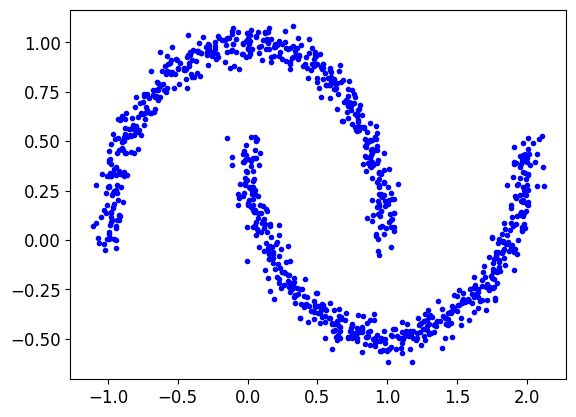

In [63]:
plt.plot(X[:,0],X[:,1],'b.')

In [64]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.05,min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [65]:
dbscan.labels_[:10] #这里的-1代表离群点

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [66]:
dbscan.core_sample_indices_[:10] #核心对象索引

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [67]:
np.unique(dbscan.labels_) #可以看看特殊值

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [68]:
dbscan2 = DBSCAN(eps = 0.2,min_samples=5)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [69]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

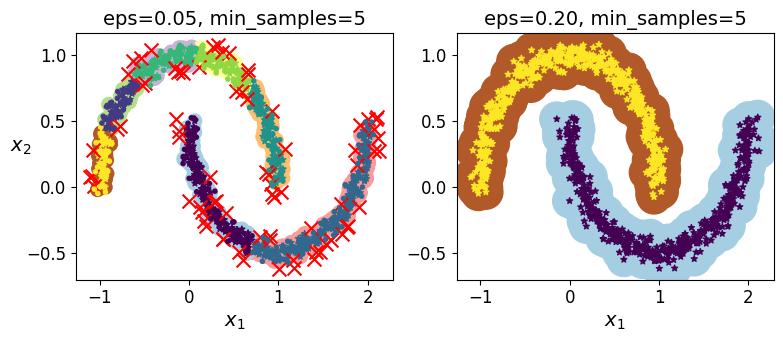

In [70]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

**DBSCAN算法中最核心的就是半径，半径大小不同影响也不同**